# FI-2Pop demo

Demo notebook on the integration of FI-2Pop with the L-System.

## Imports

In [1]:
import json

GECCO-compatible `matplotlib` options:

In [2]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

Import `PCGSEPy` modules:

In [3]:
from pcgsepy.common.vecs import orientation_from_str, Vec 
from pcgsepy.config import COMMON_ATOMS, HL_ATOMS, N_ITERATIONS, REQ_TILES 
from pcgsepy.lsystem.rules import RuleMaker
from pcgsepy.lsystem.actions import AtomAction, Rotations
from pcgsepy.lsystem.parser import HLParser, LLParser
from pcgsepy.lsystem.solver import LSolver
from pcgsepy.lsystem.constraints import ConstraintHandler, ConstraintLevel, ConstraintTime
from pcgsepy.lsystem.constraints_funcs import components_constraint, intersection_constraint, symmetry_constraint, wheels_plane_constraint
from pcgsepy.lsystem.lsystem import LSystem
from pcgsepy.structure import block_definitions

## Setup

In [4]:
import logging

logging.basicConfig()
logger = logging.getLogger('base-logger')
logger.setLevel(logging.WARNING)

In [5]:
with open(COMMON_ATOMS, "r") as f:
    common_alphabet = json.load(f)

for k in common_alphabet:
    action, args = common_alphabet[k]["action"], common_alphabet[k]["args"]
    action = AtomAction(action)
    if action == AtomAction.MOVE:
        args = orientation_from_str[args]
    elif action == AtomAction.ROTATE:
        args = Rotations(args)
    common_alphabet[k] = {"action": action, "args": args}

In [6]:
with open(HL_ATOMS, "r") as f:
    hl_atoms = json.load(f)

tiles_dimensions = {}
tiles_block_offset = {}
for tile in hl_atoms.keys():
    dx, dy, dz = hl_atoms[tile]["dimensions"]
    tiles_dimensions[tile] = Vec.v3i(dx, dy, dz)
    tiles_block_offset[tile] = hl_atoms[tile]["offset"]

hl_alphabet = {}
for k in common_alphabet.keys():
    hl_alphabet[k] = common_alphabet[k]

for hk in hl_atoms.keys():
    hl_alphabet[hk] = {"action": AtomAction.PLACE, "args": []}

In [7]:
ll_alphabet = {}

for k in common_alphabet.keys():
    ll_alphabet[k] = common_alphabet[k]

for k in block_definitions.keys():
    if k != "":  # TODO: This is a probable bug, reported to the SE API devs
        ll_alphabet[k] = {"action": AtomAction.PLACE, "args": [k]}

## L-System components

In [8]:
hl_rules = RuleMaker(ruleset='hlrules').get_rules()
ll_rules = RuleMaker(ruleset='llrules').get_rules()

hl_parser = HLParser(rules=hl_rules)
ll_parser = LLParser(rules=ll_rules)

hl_solver = LSolver(parser=hl_parser,
                    atoms_alphabet=hl_alphabet,
                    extra_args={
                        'tiles_dimensions': tiles_dimensions,
                        'tiles_block_offset': tiles_block_offset,
                        'll_rules': ll_rules
                    })
ll_solver = LSolver(parser=ll_parser,
                    atoms_alphabet=dict(hl_alphabet, **ll_alphabet),
                    extra_args={})

In [9]:
rcc = ConstraintHandler(
    name="required_components",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.END,
    f=components_constraint,
    extra_args={
        'alphabet': hl_alphabet
    }
)
rcc.extra_args["req_tiles"] = REQ_TILES

nic = ConstraintHandler(
    name="no_intersections",
    level=ConstraintLevel.HARD_CONSTRAINT,
    when=ConstraintTime.DURING,
    f=intersection_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    },
    needs_ll=True
)
nic.extra_args["tiles_dimensions"] = tiles_dimensions

sc = ConstraintHandler(
    name="symmetry",
    level=ConstraintLevel.SOFT_CONSTRAINT,
    when=ConstraintTime.END,
    f=symmetry_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    }
)

wopc = ConstraintHandler(
    name="wheels_on_plane",
    level=ConstraintLevel.SOFT_CONSTRAINT,
    when=ConstraintTime.END,
    f=wheels_plane_constraint,
    extra_args={
        'alphabet': dict(hl_alphabet, **ll_alphabet)
    }
)

In [10]:
lsystem = LSystem(
    hl_solver=hl_solver, ll_solver=ll_solver
)

In [11]:
lsystem.add_hl_constraint(c=rcc)
lsystem.add_hl_constraint(c=nic)

lsystem.add_ll_constraint(c=sc)
lsystem.add_ll_constraint(c=wopc)

## FI-2Pop

In [12]:
from typing import Any, Dict, List, Tuple
from pcgsepy.lsystem.lsystem import LSystem

pops_size = 50
n_retries = 100


def subdivide_axioms(hl_axioms: List[str],
                     lsystem: LSystem) -> Dict[str, Any]:
    axioms_sats = {}
    for hl_axiom in hl_axioms:
        axioms_sats[hl_axiom] = {
            'feasible': True,
            'n_constraints_v': 0
        }
        for t in [ConstraintTime.DURING, ConstraintTime.END]:
            sat = lsystem.hlsolver._check_constraints(axiom=hl_axiom,
                                                      when=t,
                                                      keep_track=True)
            axioms_sats[hl_axiom]['feasible'] &= sat[ConstraintLevel.HARD_CONSTRAINT][0]
            axioms_sats[hl_axiom]['n_constraints_v'] += sat[ConstraintLevel.HARD_CONSTRAINT][1]
            axioms_sats[hl_axiom]['n_constraints_v'] += sat[ConstraintLevel.SOFT_CONSTRAINT][1]

    to_expand_further = []
    for hl_axiom in axioms_sats.keys():
        if axioms_sats[hl_axiom]['feasible']:
            to_expand_further.append(hl_axiom)

    ml_axioms = lsystem.get_ml_axioms(hl_axioms=to_expand_further)
    for i, ml_axiom in enumerate(ml_axioms):
        for t in [ConstraintTime.DURING, ConstraintTime.END]:
            ll_axiom = LLParser(rules=lsystem.hlsolver.ll_rules).expand(axiom=ml_axiom)
            sat = lsystem.llsolver._check_constraints(axiom=ll_axiom,
                                                      when=t,
                                                      keep_track=True)
            axioms_sats[to_expand_further[i]]['feasible'] &= sat[ConstraintLevel.HARD_CONSTRAINT][0]
            axioms_sats[to_expand_further[i]]['n_constraints_v'] += sat[ConstraintLevel.HARD_CONSTRAINT][1]
            axioms_sats[to_expand_further[i]]['n_constraints_v'] += sat[ConstraintLevel.SOFT_CONSTRAINT][1]

    return axioms_sats


def generate_initial_populations(lsystem: LSystem,
                                 pops_size: int = 50,
                                 n_retries: int = 100) -> Tuple[List[str], List[str], List[float]]:
    feasible_pop, infeasible_pop = [], []
    inf_fitnesses = []
    i = 0
    lsystem.check_sat = False
    while len(feasible_pop) < pops_size or len(infeasible_pop) < pops_size:
        hl_axioms = lsystem.get_hl_axioms(starting_axiom="begin",
                                          iterations=N_ITERATIONS)
        axioms_sats = subdivide_axioms(hl_axioms=hl_axioms,
                                       lsystem=lsystem)
        for axiom in axioms_sats.keys():
            if axioms_sats[axiom]['feasible'] and len(feasible_pop) < pops_size and axiom not in feasible_pop:
                feasible_pop.append(axiom)
            elif not axioms_sats[axiom]['feasible'] and len(infeasible_pop) < pops_size and axiom not in feasible_pop:
                infeasible_pop.append(axiom)
                inf_fitnesses.append(axioms_sats[axiom]['n_constraints_v'])
        i += 1
        if i == n_retries:
            break
    return feasible_pop, infeasible_pop, inf_fitnesses

In [13]:
def compute_fitness(axiom: str) -> float:
    return float(len(axiom))

In [14]:
from random import random
from typing import List


def roulette_wheel_selection(axioms: List[str],
                             fitnesses: List[float]) -> str:
    s = sum(fitnesses)
    r = s * random()
    p = 0.
    for i, f in enumerate(fitnesses):
        p += f
        if p >= r:
            return axioms[i]
    raise Exception('Unable to find axiom')

In [15]:
from pcgsepy.lsystem.parser import HLtoMLTranslator

translator = HLtoMLTranslator(alphabet=hl_alphabet,
                              tiles_dims=tiles_dimensions,
                              tiles_block_offset={})

In [16]:
from pcgsepy.evo.genops import crossover, mutate


def create_new_pool(population: List[str],
                    fitnesses: List[float],
                    generation: int,
                    n_individuals: int = 50) -> List[str]:
    pool = []

    while len(pool) < n_individuals:
        # fitness-proportionate selection
        p1 = roulette_wheel_selection(axioms=population,
                                      fitnesses=fitnesses)
        p2 = roulette_wheel_selection(axioms=population,
                                      fitnesses=fitnesses)
        # crossover
        o1, o2 = crossover(a1=p1,
                           a2=p2,
                           n_childs=2,
                           translator=translator)
        # mutation
        o1 = mutate(axiom=o1,
                    translator=translator,
                    n_iteration=generation)
        o2 = mutate(axiom=o2,
                    translator=translator,
                    n_iteration=generation)

        for o in [o1, o2]:
            if o not in pool:
                pool.append(o)

    return pool

In [17]:
def reduce_population(population: List[str],
                      fitnesses: List[str],
                      to: int) -> Tuple[List[str], List[str]]:
    f_ordered_idxs = [i for _, i in sorted(zip(fitnesses, range(len(fitnesses))))][-to:]
    red_pop, red_f = [], []
    for i in f_ordered_idxs:
        red_pop.append(population[i])
        red_f.append(fitnesses[i])
    return red_pop, red_f

In [18]:
def if2pop(f_pop: List[str],
           i_pop: List[str],
           f_fitnesses: List[float],
           i_fitnesses: List[float],
           n_iter: int) -> Tuple[List[str], List[str]]:    
    f_pool = []
    i_pool = []

    f_pool_fitnesses = []
    i_pool_fitnesses = []
    for gen in range(n_iter):
        # create offsprings from feasible population
        new_pool = create_new_pool(population=f_pop,
                                   fitnesses=f_fitnesses,
                                   generation=gen)
        # if feasible, add to feasible pool
        # if infeasible, add to infeasible pool
        axioms_sats = subdivide_axioms(hl_axioms=new_pool,
                                       lsystem=lsystem)
        for axiom in axioms_sats.keys():
            if axioms_sats[axiom]['feasible']:
                f_pool.append(axiom)
                f_pool_fitnesses.append(compute_fitness(axiom=axiom))
            else:
                i_pool.append(axiom)
                i_pool_fitnesses.append(axioms_sats[axiom]['n_constraints_v'])
        # place the infeasible population in the infeasible pool
        i_pool.extend(i_pop)
        i_pool_fitnesses.extend(i_fitnesses)
        # reduce the infeasible pool if > pops_size
        if len(i_pool) > pops_size:
            i_pool, i_pool_fitnesses = reduce_population(population=i_pool,
                                                         fitnesses=i_pool_fitnesses,
                                                         to=pops_size)
        # set the infeasible pool as the infeasible population
        i_pop[:] = i_pool[:]
        i_fitnesses[:] = i_pool_fitnesses[:]
        # create offsprings from infeasible population
        new_pool = create_new_pool(population=i_pop,
                                   fitnesses=i_fitnesses,
                                   generation=gen)
        # if feasible, add to feasible pool
        # if infeasible, add to infeasible pool
        axioms_sats = subdivide_axioms(hl_axioms=new_pool,
                                       lsystem=lsystem)
        for axiom in axioms_sats.keys():
            if axioms_sats[axiom]['feasible']:
                f_pool.append(axiom)
                f_pool_fitnesses.append(compute_fitness(axiom=axiom))
            else:
                i_pool.append(axiom)
                i_pool_fitnesses.append(axioms_sats[axiom]['n_constraints_v'])
        # reduce the feasible pool if > pops_size
        if len(f_pool) > pops_size:
            f_pool, f_pool_fitnesses = reduce_population(population=f_pool,
                                                         fitnesses=f_pool_fitnesses,
                                                         to=pops_size)
        # set the feasible pool as the feasible population
        f_pop[:] = f_pool[:]
        f_fitnesses[:] = f_pool_fitnesses[:]

    return f_pop, i_pop

In [19]:
f_pop, i_pop, i_fitnesses = generate_initial_populations(lsystem=lsystem)
f_fitnesses = [compute_fitness(a) for a in f_pop]

print(len(f_pop), len(i_pop))
print(max(f_fitnesses), min(i_fitnesses))

50 50
132.0 1


In [20]:
if2pop(f_pop=f_pop,
       i_pop=i_pop,
       f_fitnesses=f_fitnesses,
       i_fitnesses=i_fitnesses,
       n_iter=2)

print(len(f_pop), len(i_pop))
print(max(f_fitnesses), min(i_fitnesses))

50 50
181.0 2


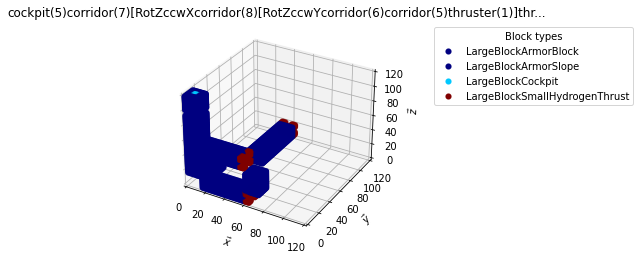

In [21]:
from pcgsepy.lsystem.structure_maker import LLStructureMaker
from pcgsepy.common.vecs import Orientation
from pcgsepy.structure import Structure

hl_axiom = f_pop[f_fitnesses.index(max(f_fitnesses))]
ml_axiom = lsystem.hlsolver.translator.transform(axiom=hl_axiom)
ll_axiom = lsystem.llsolver.solve(axiom=ml_axiom,
                                  iterations=1,
                                  axioms_per_iteration=1,
                                  check_sat=False)[0]

base_position, orientation_forward, orientation_up = Vec.v3i(
            0, 0, 0), Orientation.FORWARD.value, Orientation.UP.value
structure = Structure(origin=base_position,
                      orientation_forward=orientation_forward,
                      orientation_up=orientation_up)
structure = LLStructureMaker(
    atoms_alphabet=lsystem.llsolver.atoms_alphabet,
    position=base_position).fill_structure(structure=structure,
                                           axiom=ll_axiom)
structure.sanify()
structure.show(title=hl_axiom)